In [1]:
# %pip install kagglehub
# %pip install monai
# %pip install ipywidgets
# %pip install pillow tensorflow
# %pip install opencv-python
# %pip install matplotlib
# %pip install scikit-learn
# %pip install pandas
# %pip install seaborn

In [26]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from monai.transforms import ScaleIntensity
import kagglehub

#### Download latest version https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [3]:
path = kagglehub.dataset_download(r"navoneel/brain-mri-images-for-brain-tumor-detection")
# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [4]:
dataset_path_tumor = f'{path}/brain_tumor_dataset/yes'
dataset_path_norma = f'{path}/brain_tumor_dataset/no'

#### Count files in directory

In [5]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])

print("Length dataset_path_tumor:", count_images(dataset_path_tumor))
print("Length dataset_path_norma:", count_images(dataset_path_norma))

Length dataset_path_tumor: 155
Length dataset_path_norma: 98


#### Check data

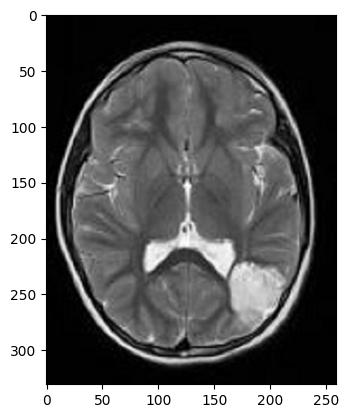

In [6]:
mri_image = cv2.imread(f'{dataset_path_tumor}/Y249.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(mri_image, cmap='gray')

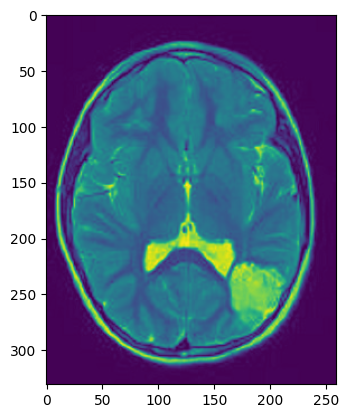

In [7]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
mri_image_scaled = transform_img(mri_image)
colored_mri = cm.viridis(mri_image_scaled)
plt.imshow(colored_mri)

#### Load and preprocess the images

In [8]:
img_size = (224, 224)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

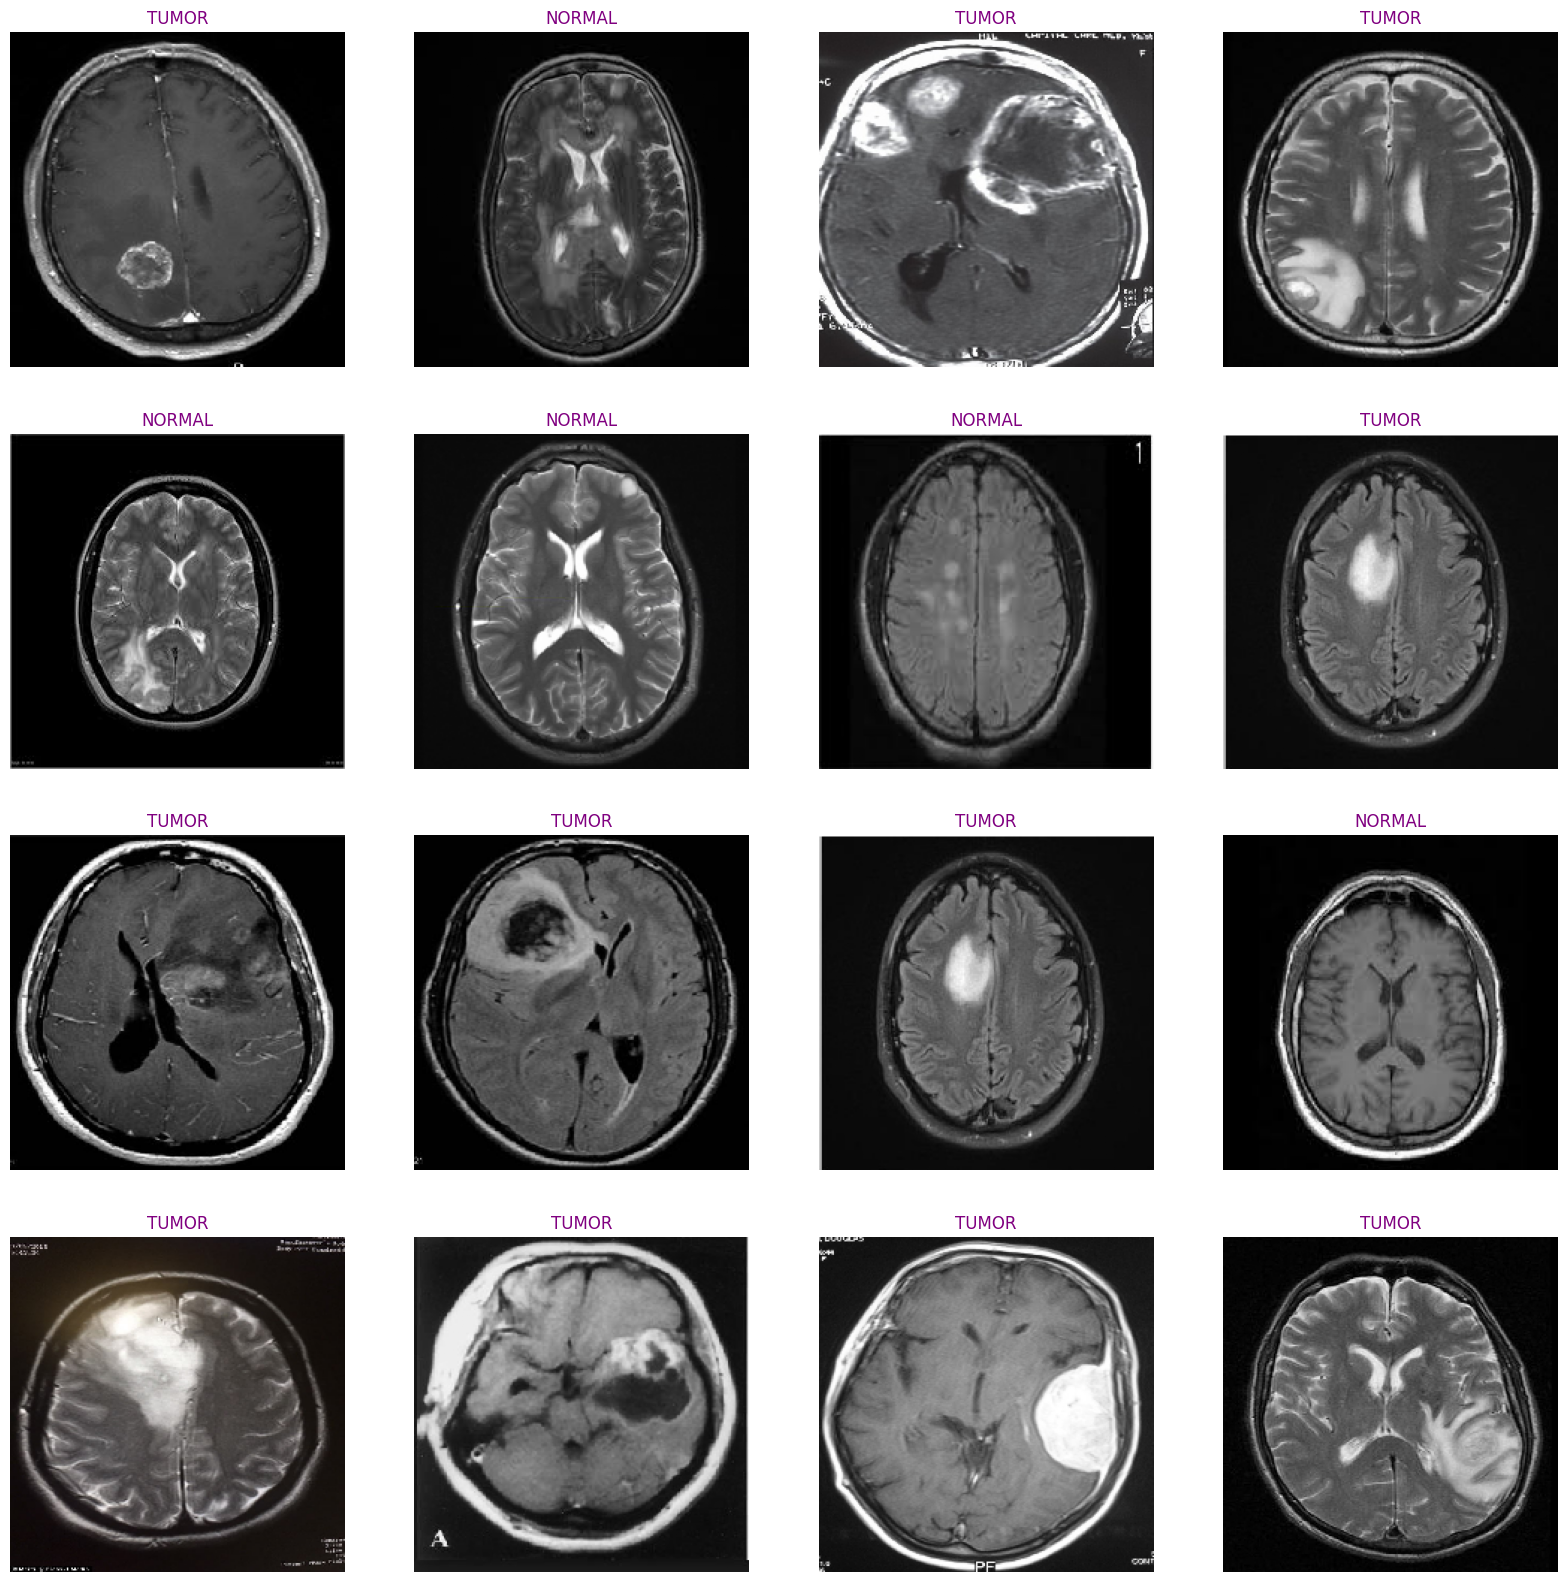

In [9]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

tumor_filepaths, tumor_labels = load_file_paths_and_labels(dataset_path_tumor, 'TUMOR')
normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_norma, 'NORMAL')

all_filepaths = tumor_filepaths + normal_filepaths
all_labels = tumor_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'TUMOR': 0, 'NORMAL': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='purple', fontsize=12)
    plt.axis('off')

plt.show()

#### Get training and testing data

In [10]:
tumor_data, tumor_labels = load_and_limit_data(dataset_path_tumor, label=1, num_samples=155)
normal_data, normal_labels = load_and_limit_data(dataset_path_norma, label=0, num_samples=98)

all_data = tumor_data + normal_data
all_labels = tumor_labels + normal_labels

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

#### Quantum CNN model

In [11]:
class QuantumCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flattened_size = self._get_flattened_size(img_size[0])

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self, size):
        size = size // 2
        size = size // 2
        size = size // 2
        return 128 * size * size

    def forward(self, x):
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(self.bn2(torch.relu(self.conv2(x))))
        x = self.pool(self.bn3(torch.relu(self.conv3(x))))
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Initialize the model, criterion, and optimizer

In [12]:
quantum_model = QuantumCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(quantum_model.parameters(), lr=0.0001)

#### Compute class weights - convert classes to a numpy array

In [13]:
if y_train.ndim == 1:
    y_labels = y_train
else:
    y_labels = np.argmax(y_train, axis=1)

In [14]:
classes = np.array([0, 1]) 
class_weights = compute_class_weight('balanced', classes=classes, y=y_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

#### Display the categorized file paths and labels

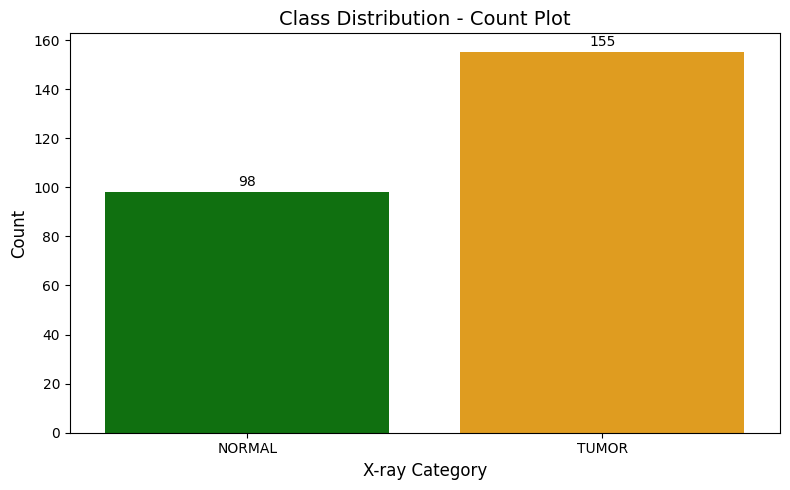

In [15]:
file_paths_tumor = [os.path.join(dataset_path_tumor, fname) for fname in os.listdir(dataset_path_tumor)]
file_paths_norma = [os.path.join(dataset_path_norma, fname) for fname in os.listdir(dataset_path_norma)]
file_paths = file_paths_norma + file_paths_tumor
labels = [0] * len(normal_labels) + [1] * len(tumor_labels)

df = pd.DataFrame({'filepaths': file_paths, 
                   'labels': ['NORMAL' if lbl == 0 else 'TUMOR' for lbl in labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='labels',
    hue='labels',
    palette={'NORMAL': 'green', 'TUMOR': 'orange'},
    dodge=False,
    legend=False
)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('X-ray Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()

#### Function to train the model

In [18]:
def fit_quantum_model(model, X_train, y_train, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    history = []

    batch_size, n_features = X_train.shape
    channels = 3 
    height, width = 224, 224
    
    for epoch in range(epochs):
        optimizer.zero_grad()

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(batch_size, channels, height, width)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)

        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, dim=1)
        correct = (predicted == y_train_tensor).sum().item()
        accuracy = 100 * correct / batch_size

        history.append({'loss': loss.item(), 'accuracy': accuracy})
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

    return history


#### Fit the model

In [19]:
quantum_history = fit_quantum_model(quantum_model, X_train, y_train, epochs=20)

Epoch [1/20], Loss: 0.7126, Accuracy: 42.57%
Epoch [2/20], Loss: 15.5379, Accuracy: 67.33%
Epoch [3/20], Loss: 3.5248, Accuracy: 76.73%
Epoch [4/20], Loss: 1.4335, Accuracy: 64.85%
Epoch [5/20], Loss: 1.3470, Accuracy: 76.24%
Epoch [6/20], Loss: 1.0418, Accuracy: 85.15%
Epoch [7/20], Loss: 0.7475, Accuracy: 88.12%
Epoch [8/20], Loss: 0.3220, Accuracy: 88.61%
Epoch [9/20], Loss: 0.7434, Accuracy: 70.30%
Epoch [10/20], Loss: 0.1095, Accuracy: 96.04%
Epoch [11/20], Loss: 0.1470, Accuracy: 93.56%
Epoch [12/20], Loss: 0.1835, Accuracy: 93.07%
Epoch [13/20], Loss: 0.1594, Accuracy: 93.07%
Epoch [14/20], Loss: 0.1058, Accuracy: 95.05%
Epoch [15/20], Loss: 0.0637, Accuracy: 98.51%
Epoch [16/20], Loss: 0.0483, Accuracy: 99.50%
Epoch [17/20], Loss: 0.0532, Accuracy: 99.50%
Epoch [18/20], Loss: 0.0547, Accuracy: 100.00%
Epoch [19/20], Loss: 0.0441, Accuracy: 100.00%
Epoch [20/20], Loss: 0.0301, Accuracy: 100.00%


#### Save model

In [21]:
torch.save(quantum_model.state_dict(), "models/quantum_torch_brain_tumor_detection.pth")

#### Load the State Dictionary

In [ ]:
model = QuantumCNN()
model.load_state_dict(torch.load("models/quantum_torch_brain_tumor_detection.pth"))
model.eval()

#### Compute evaluation metrics

In [24]:
X_test_np = np.array(X_test)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).view(-1, 3, 224, 224)

y_test_tensor = torch.tensor(y_test, dtype=torch.long)

with torch.no_grad():
    outputs = quantum_model(X_test_tensor)
    y_pred_probs = torch.softmax(outputs, dim=1)
    y_pred = torch.argmax(y_pred_probs, axis=1).numpy()

if isinstance(y_test, torch.Tensor):
    y_test = y_test.numpy()

classification_rep = metrics.classification_report(y_test, y_pred, output_dict=True, zero_division=1)

conf_matrix = metrics.confusion_matrix(y_test, y_pred)
try:
    roc_auc = metrics.roc_auc_score(y_test, y_pred_probs.numpy(), multi_class='ovr')
except ValueError:
    roc_auc = "ROC AUC not applicable for this setup."

print("Classification Report:", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report: {'0': {'precision': 0.9375, 'recall': 0.625, 'f1-score': 0.75, 'support': 24.0}, '1': {'precision': 0.7428571428571429, 'recall': 0.9629629629629629, 'f1-score': 0.8387096774193549, 'support': 27.0}, 'accuracy': 0.803921568627451, 'macro avg': {'precision': 0.8401785714285714, 'recall': 0.7939814814814814, 'f1-score': 0.7943548387096775, 'support': 51.0}, 'weighted avg': {'precision': 0.8344537815126051, 'recall': 0.803921568627451, 'f1-score': 0.7969639468690701, 'support': 51.0}}
Confusion Matrix:
 [[15  9]
 [ 1 26]]
ROC AUC Score: ROC AUC not applicable for this setup.


#### Predicted probability for Positive Class

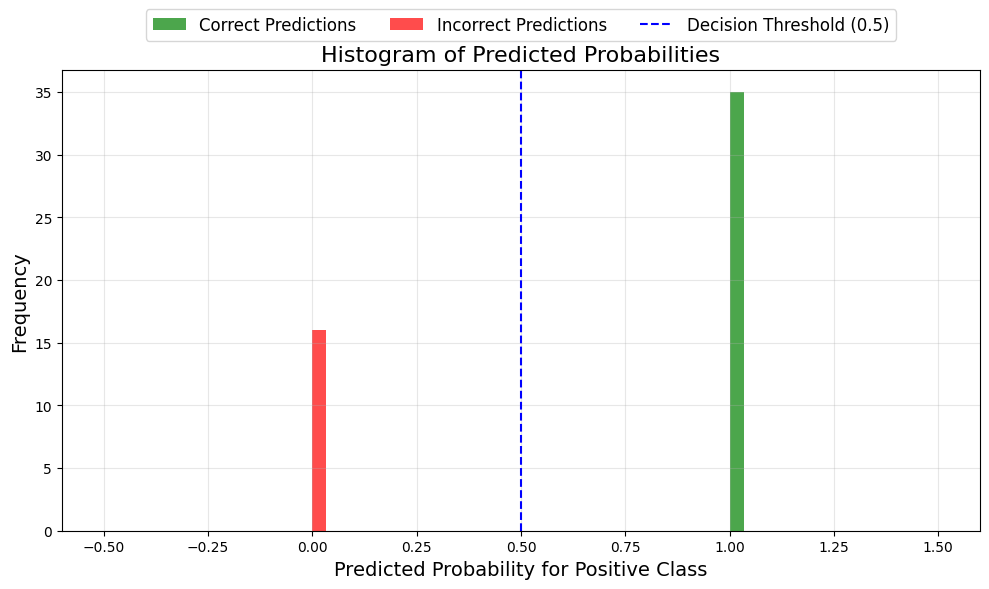

In [25]:
if isinstance(y_pred, np.ndarray):
    y_pred = torch.tensor(y_pred, dtype=torch.float32)

predictions = torch.round(y_pred)
correct_predictions = (predictions == 1)
incorrect_predictions = ~correct_predictions

correct_probs = y_pred[correct_predictions]
incorrect_probs = y_pred[incorrect_predictions]

plt.figure(figsize=(10, 6))

plt.hist(
    correct_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='green', 
    label='Correct Predictions'
)

plt.hist(
    incorrect_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='red', 
    label='Incorrect Predictions'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### PCA of model prediction

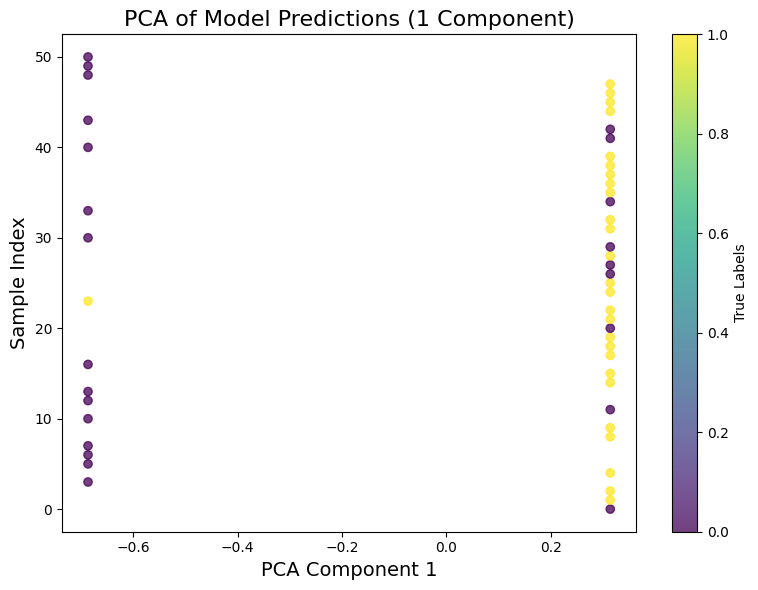

In [27]:
if y_pred.ndim == 1:
    labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))

plt.scatter(features_pca, range(len(features_pca)), c=y_test, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

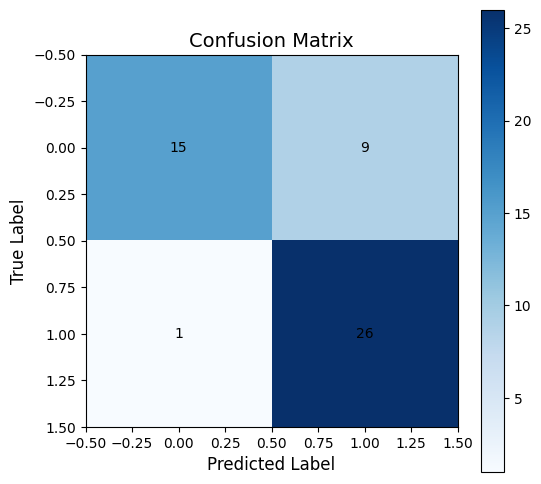

In [28]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()